# Второе задание по вычислительной математике. Гиперболические системы уравнений

Рассматривается задача

\begin{equation}
\frac{\partial \mathbf{u}}{\partial t}+\mathbf{A} \frac{\partial \mathbf{u}}{\partial x}=\mathbf{b}(x), 0 \leqslant x \leqslant 1,0 \leqslant t \leqslant 1, \quad \mathbf{u}(x, 0)=\left( \begin{array}{c}{x^{3}} \\ {1-x^{2}} \\ {x^{2}+1}\end{array}\right)
\end{equation}

\begin{equation}
\mathbf{A}=\left( \begin{array}{ccc}{-28} & {109} & {-63} \\ {-14} & {53} & {-30} \\ {-13} & {47} & {-26}\end{array}\right), \mathbf{b}(x)=\left( \begin{array}{l}{0} \\ {0} \\ {0}\end{array}\right)
\end{equation}

## Часть 1. Приведение системы к характеристическому виду

Выполним спектральное разложение матрицы $A$ системы:
\begin{equation}
A=P D P^{-1}
\end{equation}

\begin{equation}
A = \left( \begin{array}{ccc}{-28} & {109} & {-63} \\ {-14} & {53} & {-30} \\ {-13} & {47} & {-26}\end{array}\right) = \left( \begin{array}{ccc}{\frac{1}{3}} & {5} & {2} \\ {\frac{2}{3}} & {2} & {1} \\ {1} & {1} & {1}\end{array}\right) \left( \begin{array}{ccc}{1} & {0} & {0} \\ {0} & {3} & {0} \\ {0} & {0} & {-5}\end{array}\right) \left( \begin{array}{ccc}{-\frac{3}{2}} & {\frac{9}{2}} & {-\frac{3}{2}} \\ {-\frac{1}{2}} & {\frac{5}{2}} & {-\frac{3}{2}} \\ {2} & {-7} & {4}\end{array}\right)
\end{equation}

С учётом разложения система принимает вид:
\begin{equation}
\frac{\partial \mathbf{u}}{\partial t}+\mathbf{P D P^{-1}} \frac{\partial \mathbf{u}}{\partial x}=0
\end{equation}

Домножая слева на $P^{-1}$, получим систему в характеристическом виде:
\begin{equation}
\frac{\partial \mathbf{R}}{\partial t}+\mathbf{D} \frac{\partial \mathbf{R}}{\partial x}=0
\end{equation}
где $\mathbf{R}=\mathbf{P^{-1}u}$

В итоге получаем следующую систему уравнений:
\begin{equation}
\begin{cases} \frac{\partial R_1}{\partial t}+ \frac{\partial R_1}{\partial x}=0 \\ \frac{\partial R_2}{\partial t}+ 3\frac{\partial R_2}{\partial x}=0 \\ \frac{\partial R_3}{\partial t}- 5\frac{\partial R_3}{\partial x}=0 \end{cases}
\end{equation}

Начальные условия для инвариантов Римана:
\begin{equation}
\mathbf{R}(x, 0) = \left( \begin{array}{c}{\frac{-3 x^{3}-12 x^{2}+6}{2}} \\ {\frac{-x^{3}-8 x^{2}+2}{2}} \\ {2 x^{3}+11 x^{2}-3}\end{array}\right)
\end{equation}
Восстановление естественных переменных возможно по формуле:
\begin{equation}
\mathbf{u}=\mathbf{PR}
\end{equation}

# Часть 2. Схема Куранта-Изаксона-Риса

Для первого и второго уравнения системы применима схема:
\begin{equation}
\frac{u_{m}^{n+1}-u_{m}^{n}}{\tau}+a \frac{u_{m}^{n}-u_{m-1}^{n}}{h}=0
\end{equation}

Перепишем её для третьего уравнения, где $a<0$:
\begin{equation}
\frac{u_{m}^{n+1}-u_{m}^{n}}{\tau}+a \frac{u_{m+1}^{n}-u_{m}^{n}}{h}=0
\end{equation}

Согласно определению Фридрихса, данные схемы не являются монотонными. Первое дифференциальное приближение запишется следующим образом:
\begin{equation}
r_{\tau h}=L u-\frac{c h}{2}\left(1-\frac{c \tau}{h}\right) \frac{\partial^{2} u}{\partial x^{2}}+O\left(\tau^{2}+h^{2}\right)
\end{equation}
Можно видеть, что преобладает диссипативная ошибка. А теперь перейдём к реализации схемы:

In [1]:
import abc
import numpy as np

class TwoLayerDifferenceScheme(object):
    def __init__(self, t0, te, x0, xe, xsteps, tsteps, init: callable):
        self.t = t0
        self.te = te
        self.xgrid = np.linspace(x0, xe, xsteps + 1)
        self.h = self.xgrid[1] - self.xgrid[0]
        self.tgrid = np.linspace(t0, te, tsteps + 1)
        self.tau = self.tgrid[1] - self.tgrid[0]
        self.u_current = init(self.t, self.xgrid)

    @abc.abstractmethod
    def step(self):
        raise NotImplementedError

    def solve(self):
        yield self.u_current
        while self.t < self.te:
            self.step()
            yield self.u_current

In [2]:
class KIRLeft(TwoLayerDifferenceScheme):
    def __init__(self, t0, te, x0, xe, xsteps, tsteps, init: callable, a):
        super(KIRLeft, self).__init__(t0, te, x0, xe, xsteps, tsteps, init)
        assert a > 0
        self.a = a
    def step(self):
        u = np.zeros_like(self.u_current)
        u[0] = self.u_current[0]
        for i in range(1, len(u)):
            u[i] = self.u_current[i]-(self.tau*self.a/self.h)*(self.u_current[i]-self.u_current[i-1])
        self.u_current = u
        self.t += self.tau

class KIRRight(TwoLayerDifferenceScheme):
    def __init__(self, t0, te, x0, xe, xsteps, tsteps, init: callable, a):
        super(KIRRight, self).__init__(t0, te, x0, xe, xsteps, tsteps, init)
        assert a < 0
        self.a = a
    def step(self):
        u = np.zeros_like(self.u_current)
        u[-1] = self.u_current[-1]
        for i in range(0, len(u)-1):
            u[i] = self.u_current[i]-(self.tau*self.a/self.h)*(self.u_current[i+1]-self.u_current[i])
        self.u_current = u
        self.t += self.tau

Реализованы две схемы КИР: с правым уголком для $a<0$, и с левым для $a>0$. Получим решения системы в инвариантах Римана:

In [3]:
first = KIRLeft(0,1,0,1,100,1000,lambda t, x: 0.5*(-3*x**3-12*x**2+6), 1)
R_1 = np.array(list(first.solve()))
second = KIRLeft(0,1,0,1,100,1000,lambda t, x: 0.5*(-x**3-8*x**2+2), 3)
R_2 = np.array(list(second.solve()))
third = KIRRight(0,1,0,1,100,1000,lambda t, x: 2*x**3+11*x**2-3, -5)
R_3 = np.array(list(third.solve()))

Вернёмся к естественным переменным при помощи преобразования, задаваемого матрицей $\mathbf{P}$:

In [4]:
u_1 = (1/3)*np.array(R_1) + 5*np.array(R_2) + 2*np.array(R_3)
u_2 = (2/3)*np.array(R_1) + 2*np.array(R_2) + 1*np.array(R_3)
u_3 = 1*np.array(R_1) + 1*np.array(R_2) + 1*np.array(R_3)

Визуализируем полученные результаты:

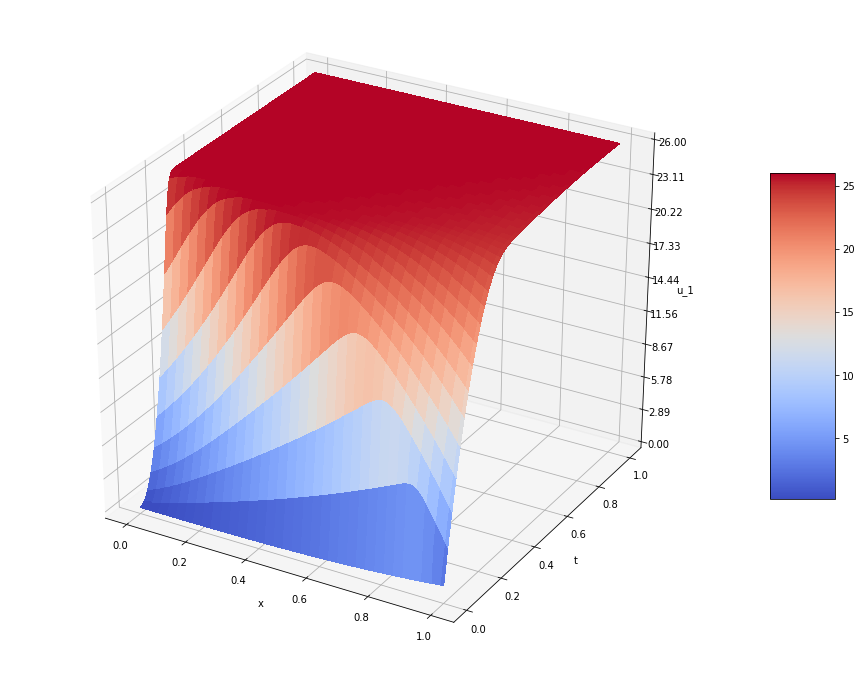

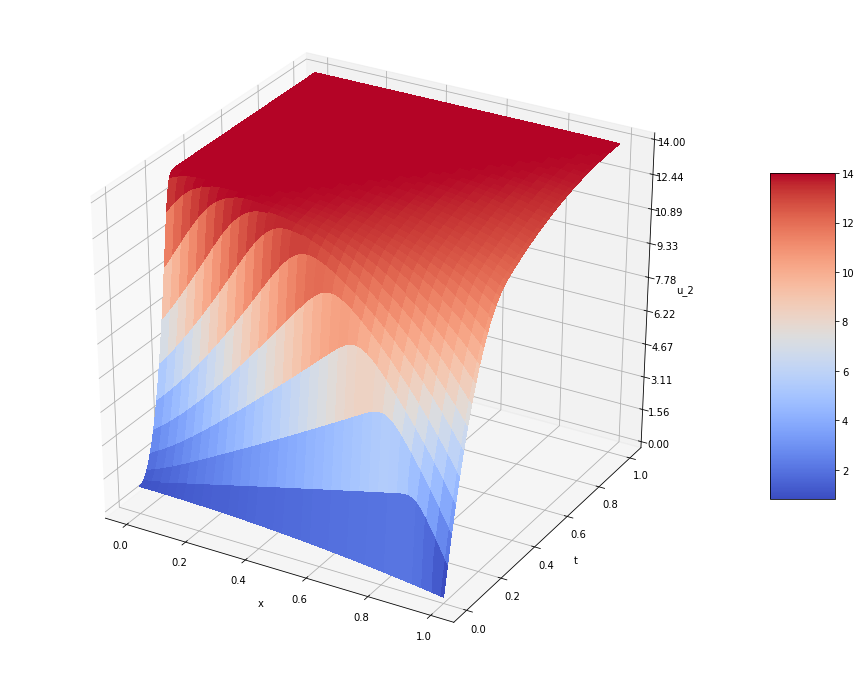

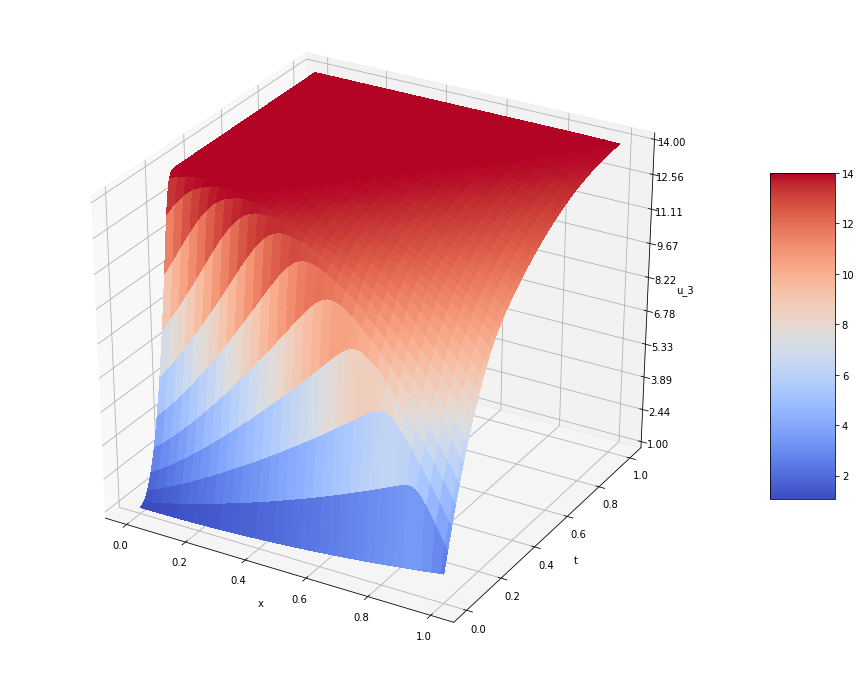

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

def plot_3d(u, label):
    fig = plt.figure(figsize=(16,12))
    ax = fig.gca(projection='3d')
    ts = first.tgrid
    xs = first.xgrid
    X, Y = np.meshgrid(xs, ts)
    surf = ax.plot_surface(X, Y, u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel(label)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

plot_3d(u_1, 'u_1')
plot_3d(u_2, 'u_2')
plot_3d(u_3, 'u_3')

## Часть 2. Схема Федоренко

\begin{equation}
\frac{u_{m}^{n+1}-u_{m}^{n}}{\tau}+\frac{u_{m}^{n}-u_{m-1}^{n}}{h}+\frac{\gamma}{2 \tau}\left(\frac{a \tau}{h}-\frac{a^{2} \tau^{2}}{h^{2}}\right)\left(u_{m+1}^{n}-2 u_{m}^{n}+u_{m-1}^{n}\right)=0
\end{equation}

\begin{equation}
\gamma=\left\{\begin{array}{ll}{1,} & {\left|y_{m-1}^{n}-2 y_{m}^{n}+y_{m+1}^{n}\right|<\xi\left|y_{m}^{n}-y_{m-1}^{n}\right|} \\ {0,} & {\left|y_{m-1}^{n}-2 y_{m}^{n}+y_{m+1}^{n}\right|>\xi\left|y_{m}^{n}-y_{m-1}^{n}\right|}\end{array}\right.
\end{equation}

Данная схема при обращении анализатора гладкости решения в ноль переходит в схему Куранта-Изаксона-Риса. Всё, что сказано о ней в предыдущей части остаётся справедливым. В случае $\gamma = 1$ получаем схему второго порядка аппроксимации. В первом дифференциальном приближении (в данном отчёте не приводится ввиду громоздкости выкладок) находятся члены с третьей производной, что говорит о преобладании дисперсионной ошибки. Согласно определению Фридрихса, схема не является монотонной.

В отлчие от предыдущего случая, для использования данного метода придётся задать граничные условия для обоих концов рассчётного отрезка. Поэтому решения, полученные при помощи предыдущих схем и схемы Федоренко, будут качественно отличаться друг от друга. Сделав это замечание, перейдём к реализации схемы:

In [7]:
class Fedorenko(TwoLayerDifferenceScheme):
    def __init__(self, t0, te, x0, xe, xsteps, tsteps, init: callable, a, xhi):
        super(Fedorenko, self).__init__(t0, te, x0, xe, xsteps, tsteps, init)
        assert xhi >= 0
        self.xhi = xhi
        self.a = a
    def step(self):
        u = np.zeros_like(self.u_current)
        u[0] = self.u_current[0]
        u[-1] = self.u_current[-1]
        for i in range(1, len(u) - 1):
            gamma = abs(self.u_current[i-1]-2*self.u_current[i]+self.u_current[i+1]) < self.xhi*abs(self.u_current[i]-self.u_current[i-1])
            u[i] = self.u_current[i]-(self.tau/self.h)*(self.u_current[i]-self.u_current[i-1])-(gamma/2)*(self.a*self.tau/self.h-(self.a*self.tau/self.h)**2)*(self.u_current[i+1]-2*self.u_current[i]+self.u_current[i-1])
        self.u_current = u
        self.t += self.tau

In [8]:
xhi = 0

first = Fedorenko(0,1,0,1,100,1000,lambda t, x: 0.5*(-3*x**3-12*x**2+6), 1, xhi)
R_1 = np.array(list(first.solve()))
second = Fedorenko(0,1,0,1,100,1000,lambda t, x: 0.5*(-x**3-8*x**2+2), 3, xhi)
R_2 = np.array(list(second.solve()))
third = Fedorenko(0,1,0,1,100,1000,lambda t, x: 2*x**3+11*x**2-3, -5, xhi)
R_3 = np.array(list(third.solve()))

In [9]:
u_1 = (1/3)*np.array(R_1) + 5*np.array(R_2) + 2*np.array(R_3)
u_2 = (2/3)*np.array(R_1) + 2*np.array(R_2) + 1*np.array(R_3)
u_3 = 1*np.array(R_1) + 1*np.array(R_2) + 1*np.array(R_3)

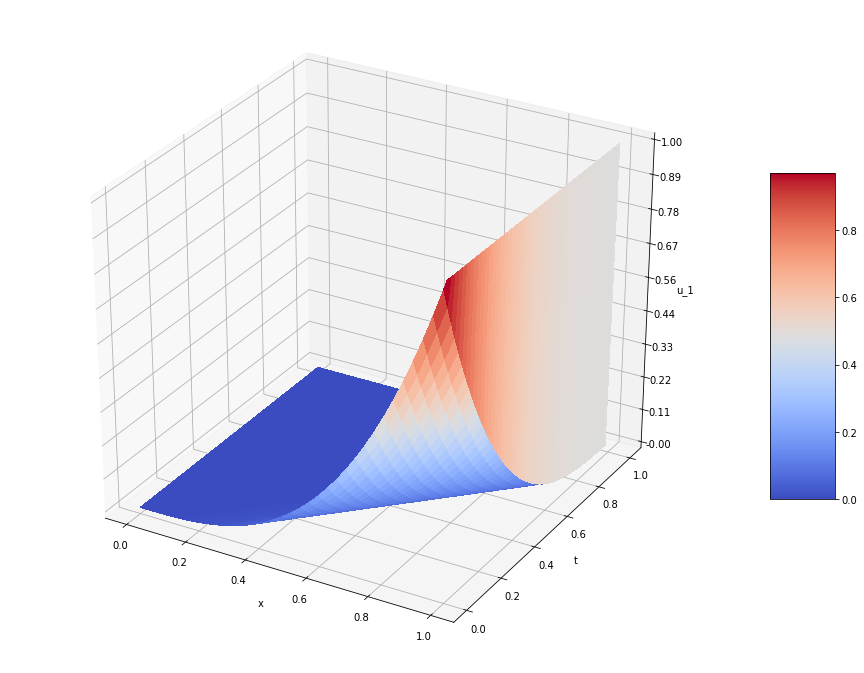

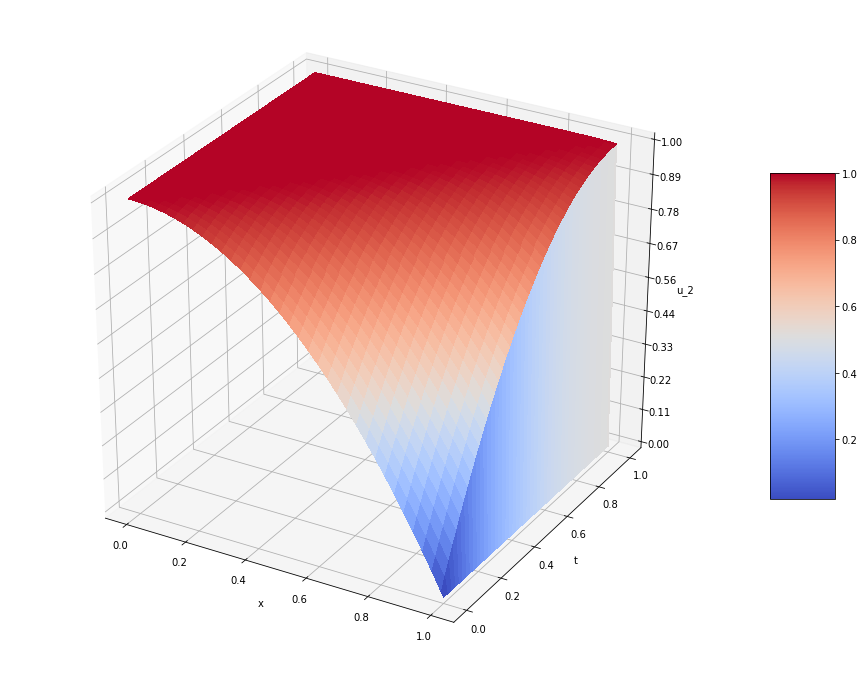

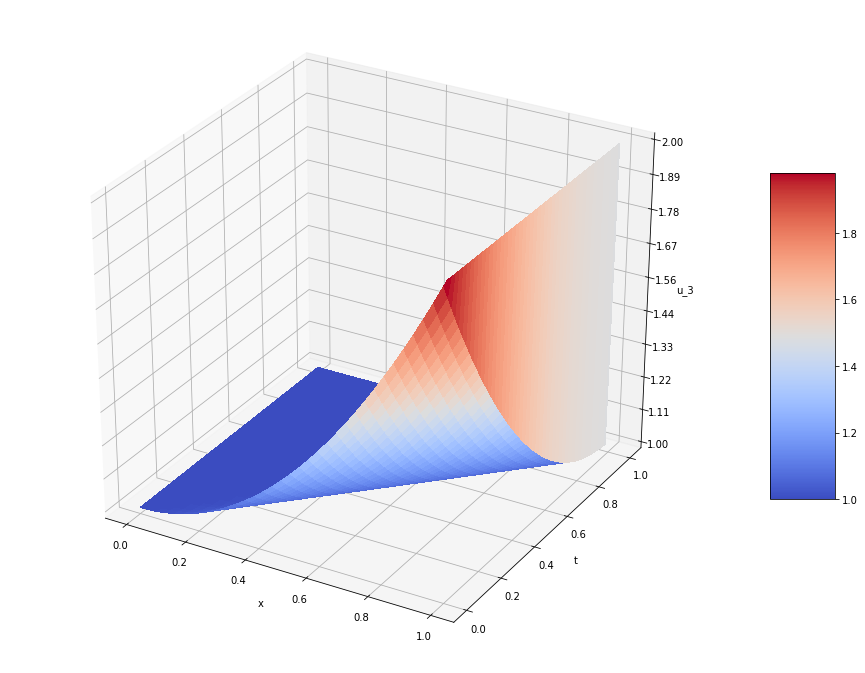

In [10]:
plot_3d(u_1, 'u_1')
plot_3d(u_2, 'u_2')
plot_3d(u_3, 'u_3')

В рассматриваемом примере при изменении параметра $\xi$ не происходит существенных изменений внешнего вида решений